# Lumiere Point Google Reviews Analysis

### Load Workspace

In [1]:
import re
import datetime as dt
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.style.use('fivethirtyeight')
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

### Load the Data

In [2]:
df = pd.read_csv('lumiere_reviews.csv')
df.head()

,reviewer,review_date,general_rating,review,extra_info,specific_ratings
0,Frank Obi,2 months ago on Google,3/5,This hotel is well situated and easy to shuttl...,Holiday ❘ Couple,Rooms3.0Service3.0Location5.0
1,Benjamin Atte,6 days ago on Google,2/5,The hotel lack maintenance and there is no val...,NaN,Rooms2.0Service2.0Location3.0
2,samsonsfit ed,a year ago on Google,1/5,Very poor service. i arrived late night from U...,Solo,Rooms1.0Service1.0Location5.0
3,Blessing Omotese Edeigba,11 months ago on Google,1/5,How can a big hotel as this with huge price li...,NaN,NaN
4,Angela,a year ago on Google,3/5,"Nice place and location, king sized bed, free ...",NaN,Rooms3.0Service3.0Location4.0


### Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviewer          132 non-null    object
 1   review_date       132 non-null    object
 2   general_rating    132 non-null    object
 3   review            72 non-null     object
 4   extra_info        16 non-null     object
 5   specific_ratings  40 non-null     object
dtypes: object(6)
memory usage: 6.3+ KB


In [4]:
df.review_date = df.review_date.str.replace(' on  Google', '')
df.general_rating = df.general_rating.str.split('/').str[0]

df.head()

,reviewer,review_date,general_rating,review,extra_info,specific_ratings
0,Frank Obi,2 months ago,3,This hotel is well situated and easy to shuttl...,Holiday ❘ Couple,Rooms3.0Service3.0Location5.0
1,Benjamin Atte,6 days ago,2,The hotel lack maintenance and there is no val...,NaN,Rooms2.0Service2.0Location3.0
2,samsonsfit ed,a year ago,1,Very poor service. i arrived late night from U...,Solo,Rooms1.0Service1.0Location5.0
3,Blessing Omotese Edeigba,11 months ago,1,How can a big hotel as this with huge price li...,NaN,NaN
4,Angela,a year ago,3,"Nice place and location, king sized bed, free ...",NaN,Rooms3.0Service3.0Location4.0


In [5]:
pattern = r'(?:Rooms(\d+\.\d+))?(?:Service(\d+\.\d+))(?:Location(\d+\.\d+))?'

# Extract values using str.extract
extracted_values = df['specific_ratings'].str.extract(pattern)

# Rename columns for clarity
extracted_values.columns = ['rooms_rating', 'service_rating', 'location_rating']
df = pd.concat([df, extracted_values], axis=1)
df.head()

,reviewer,review_date,general_rating,review,extra_info,specific_ratings,rooms_rating,service_rating,location_rating
0,Frank Obi,2 months ago,3,This hotel is well situated and easy to shuttl...,Holiday ❘ Couple,Rooms3.0Service3.0Location5.0,3.0,3.0,5.0
1,Benjamin Atte,6 days ago,2,The hotel lack maintenance and there is no val...,NaN,Rooms2.0Service2.0Location3.0,2.0,2.0,3.0
2,samsonsfit ed,a year ago,1,Very poor service. i arrived late night from U...,Solo,Rooms1.0Service1.0Location5.0,1.0,1.0,5.0
3,Blessing Omotese Edeigba,11 months ago,1,How can a big hotel as this with huge price li...,NaN,NaN,NaN,NaN,NaN
4,Angela,a year ago,3,"Nice place and location, king sized bed, free ...",NaN,Rooms3.0Service3.0Location4.0,3.0,3.0,4.0


In [6]:
pattern = r'(Rooms(\d+\.\d+)Service(\d+\.\d+)Location(\d+\.\d+)|Service(\d+\.\d+)Location(\d+\.\d+))(.+)'

# Extract values using str.extractall to get all matches in each row
extracted_values = df['specific_ratings'].str.extract(pattern)
extracted_text = extracted_values.iloc[:, -1]
extracted_text.name = 'specific_review'

df = pd.concat([df, extracted_text], axis=1)
df.head()

,reviewer,review_date,general_rating,review,extra_info,specific_ratings,rooms_rating,service_rating,location_rating,specific_review
0,Frank Obi,2 months ago,3,This hotel is well situated and easy to shuttl...,Holiday ❘ Couple,Rooms3.0Service3.0Location5.0,3.0,3.0,5.0,NaN
1,Benjamin Atte,6 days ago,2,The hotel lack maintenance and there is no val...,NaN,Rooms2.0Service2.0Location3.0,2.0,2.0,3.0,NaN
2,samsonsfit ed,a year ago,1,Very poor service. i arrived late night from U...,Solo,Rooms1.0Service1.0Location5.0,1.0,1.0,5.0,NaN
3,Blessing Omotese Edeigba,11 months ago,1,How can a big hotel as this with huge price li...,NaN,NaN,NaN,NaN,NaN,NaN
4,Angela,a year ago,3,"Nice place and location, king sized bed, free ...",NaN,Rooms3.0Service3.0Location4.0,3.0,3.0,4.0,NaN


In [7]:
date_map = {
    '2 years ago': 730,
    'a year ago': 365,
    '11 months ago': 337,
    '10 months ago': 300,
    '7 months ago': 213,
    '8 months ago': 244,
    '9 months ago': 274,
    '2 months ago': 61,
    '5 months ago': 152,
    '6 days ago': 6,
    '3 years ago': 1095,
    '3 months ago': 91,
    '6 months ago': 183,
    '2 weeks ago': 14
}

df['review_date_days'] = df['review_date'].map(date_map)
df.head()

,reviewer,review_date,general_rating,review,extra_info,specific_ratings,rooms_rating,service_rating,location_rating,specific_review,review_date_days
0,Frank Obi,2 months ago,3,This hotel is well situated and easy to shuttl...,Holiday ❘ Couple,Rooms3.0Service3.0Location5.0,3.0,3.0,5.0,NaN,61
1,Benjamin Atte,6 days ago,2,The hotel lack maintenance and there is no val...,NaN,Rooms2.0Service2.0Location3.0,2.0,2.0,3.0,NaN,6
2,samsonsfit ed,a year ago,1,Very poor service. i arrived late night from U...,Solo,Rooms1.0Service1.0Location5.0,1.0,1.0,5.0,NaN,365
3,Blessing Omotese Edeigba,11 months ago,1,How can a big hotel as this with huge price li...,NaN,NaN,NaN,NaN,NaN,NaN,337
4,Angela,a year ago,3,"Nice place and location, king sized bed, free ...",NaN,Rooms3.0Service3.0Location4.0,3.0,3.0,4.0,NaN,365


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviewer          132 non-null    object
 1   review_date       132 non-null    object
 2   general_rating    132 non-null    object
 3   review            72 non-null     object
 4   extra_info        16 non-null     object
 5   specific_ratings  40 non-null     object
 6   rooms_rating      39 non-null     object
 7   service_rating    40 non-null     object
 8   location_rating   40 non-null     object
 9   specific_review   6 non-null      object
 10  review_date_days  132 non-null    int64 
dtypes: int64(1), object(10)
memory usage: 11.5+ KB


In [9]:
df = df.drop(columns=['reviewer', 'review_date', 'specific_ratings'])

df = df.assign(
    general_rating=lambda x: x.general_rating.astype(int),
    rooms_rating=lambda x: x.rooms_rating.astype(float),
    service_rating=lambda x: x.service_rating.astype(float),
    location_rating=lambda x: x.location_rating.astype(float),
    review_date_days=lambda x: x.review_date_days.astype(int),  
)

df.head()

,general_rating,review,extra_info,rooms_rating,service_rating,location_rating,specific_review,review_date_days
0,3,This hotel is well situated and easy to shuttl...,Holiday ❘ Couple,3.0,3.0,5.0,NaN,61
1,2,The hotel lack maintenance and there is no val...,NaN,2.0,2.0,3.0,NaN,6
2,1,Very poor service. i arrived late night from U...,Solo,1.0,1.0,5.0,NaN,365
3,1,How can a big hotel as this with huge price li...,NaN,NaN,NaN,NaN,NaN,337
4,3,"Nice place and location, king sized bed, free ...",NaN,3.0,3.0,4.0,NaN,365


In [10]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return filtered_tokens

# Apply the preprocessing function to your text column
df['clean_text'] = df['review'].fillna(value='None').apply(preprocess_text)

df['clean_text'].head()

0    [hotel, well, situated, easy, shuttle, airport...
1             [hotel, lack, maintenance, value, money]
2    [poor, service, arrived, late, night, uk, want...
3    [big, hotel, huge, price, list, elevator, one,...
4    [nice, place, location, king, sized, bed, free...
Name: clean_text, dtype: object

### Exploratory Analysis

In [11]:
deep_colors = [
    '#2e921b', '#7f1b92', '#4C72B0', '#55A868',
    '#C44E52', '#8172B2', '#CCB974', '#64B5CD'
]

In [12]:
df.describe()

,general_rating,rooms_rating,service_rating,location_rating,review_date_days
count,132.000000,39.000000,40.000000,40.000000,132.000000
mean,3.712121,3.589744,3.475000,4.325000,469.522727
std,1.345222,1.271509,1.320208,0.944281,224.891813
min,1.000000,1.000000,1.000000,2.000000,6.000000
25%,3.000000,3.000000,2.000000,4.000000,337.000000
50%,4.000000,4.000000,4.000000,5.000000,365.000000
75%,5.000000,5.000000,5.000000,5.000000,730.000000
max,5.000000,5.000000,5.000000,5.000000,1095.000000


Most Recent Review:

In [13]:
print('Most recent review')
print(df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.min())].review.values)
print()
print('\nGeneral Rating:', df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.min())].general_rating.values)
print('Rooms Rating', df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.min())].rooms_rating.values)
print('Service Rating', df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.min())].service_rating.values)
print('Location Rating', df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.min())].location_rating.values)
print('How many Days Ago was Review Posted:', df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.min())].review_date_days.values)

Most recent review
['The hotel lack maintenance and there is no value for money.']


General Rating: [2]
Rooms Rating [2.]
Service Rating [2.]
Location Rating [3.]
How many Days Ago was Review Posted: [6]


Oldest Rating:

In [14]:
print('Oldest review')
print(df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.max())].review.values)
print()
print('\nGeneral Rating:', df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.max())].general_rating.values)
print('Rooms Rating', df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.max())].rooms_rating.values)
print('Service Rating', df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.max())].service_rating.values)
print('Location Rating', df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.max())].location_rating.values)
print('How many Days Ago was Review Posted:', df.loc[(df.review.notnull()) & (df.review_date_days==df.review_date_days.max())].review_date_days.values)

Oldest review
['A nice hotel located in Ajao Estate. It is situated in a location with a lot of standard hotels nearby making it easy for visitors to check out other hotels and make comparisons if necessary. A few major banks are also nearby and it is not too far from the Murtala Muhammad International Airport.']


General Rating: [3]
Rooms Rating [nan]
Service Rating [nan]
Location Rating [nan]
How many Days Ago was Review Posted: [1095]


**Review of Best & Worst Reviews**

In [15]:
best_ratings = df.loc[
    (df.review.notnull()) &
    (df.general_rating>=4) &
    (df.rooms_rating>=4) |
    (df.service_rating>=4) |
    (df.location_rating>=4)
]

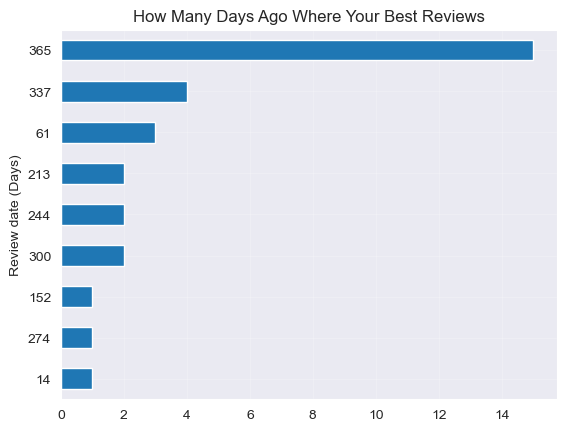

In [16]:
best_ratings.review_date_days.value_counts().plot(kind='barh', title='How Many Days Ago Where Your Best Reviews', ylabel='Review date (Days)')
plt.gca().invert_yaxis()
plt.grid(alpha=.2)
plt.show()

In [17]:
fig = px.bar(
    best_ratings.review_date_days.value_counts(),
    x=best_ratings.review_date_days.value_counts().index,
    y=best_ratings.review_date_days.value_counts(),
    title='How Many Days Ago Where Your Best Reviews',
)
fig.update_xaxes(title_text='Review date (Days)')
fig.update_yaxes(title_text='Frequency')
fig.show()

In [18]:
mid_ratings = df.loc[
    (df.review.notnull()) &
    (df.general_rating==3) &
    (df.rooms_rating==3) |
    (df.service_rating==3) |
    (df.location_rating==3)
    ]

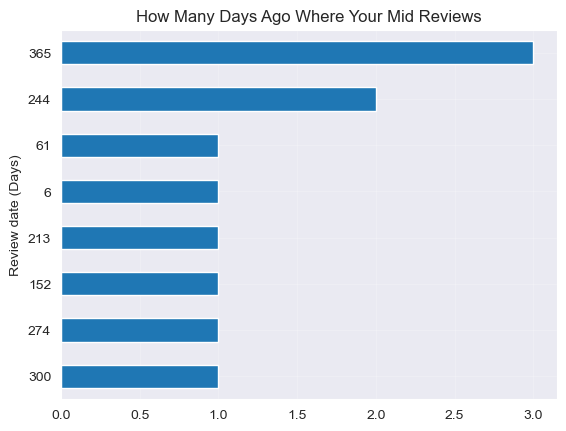

In [19]:
mid_ratings.review_date_days.value_counts().plot(kind='barh', title='How Many Days Ago Where Your Mid Reviews', ylabel='Review date (Days)')
plt.gca().invert_yaxis()
plt.grid(alpha=.2)
plt.show()

In [20]:
fig = px.bar(
    mid_ratings.review_date_days.value_counts(),
    x=mid_ratings.review_date_days.value_counts().index,
    y=mid_ratings.review_date_days.value_counts(),
    title='How Many Days Ago Where Your Mid Reviews',
)
fig.update_xaxes(title_text='Review date (Days)')
fig.update_yaxes(title_text='Frequency')
fig.show()

In [21]:
worst_ratings = df.loc[
    (df.review.notnull()) &
    (df.general_rating<=2) &
    (df.rooms_rating<=2) |
    (df.service_rating<=2) |
    (df.location_rating<=2)
    ]

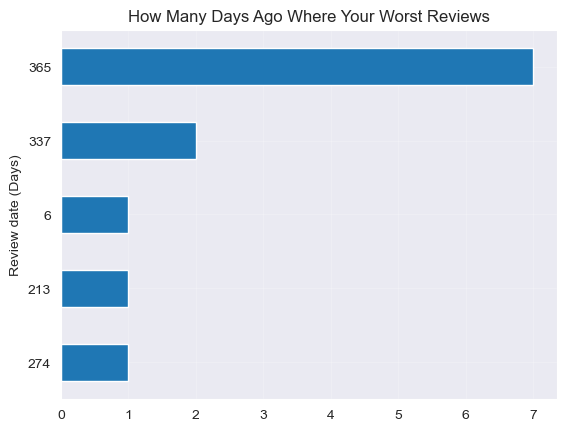

In [22]:
worst_ratings.review_date_days.value_counts().plot(kind='barh', title='How Many Days Ago Where Your Worst Reviews', ylabel='Review date (Days)')
plt.gca().invert_yaxis()
plt.grid(alpha=.2)
plt.show()

In [23]:
fig = px.bar(
    worst_ratings.review_date_days.value_counts(),
    x=worst_ratings.review_date_days.value_counts().index,
    y=worst_ratings.review_date_days.value_counts(),
    title='How Many Days Ago Where Your Worst Reviews',
)
fig.update_xaxes(title_text='Review date (Days)')
fig.update_yaxes(title_text='Frequency')
fig.show()

### Numerical Analysis

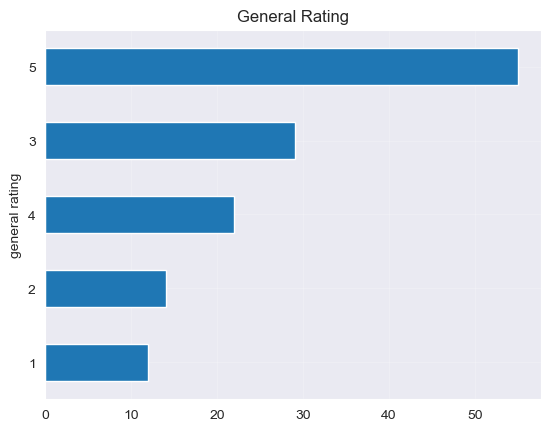

In [24]:
df.general_rating.value_counts().plot(kind='barh', title='General Rating', ylabel='general rating')
plt.gca().invert_yaxis()
plt.grid(alpha=.2)
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 10072 (\N{LIGHT VERTICAL BAR}) missing from current font.



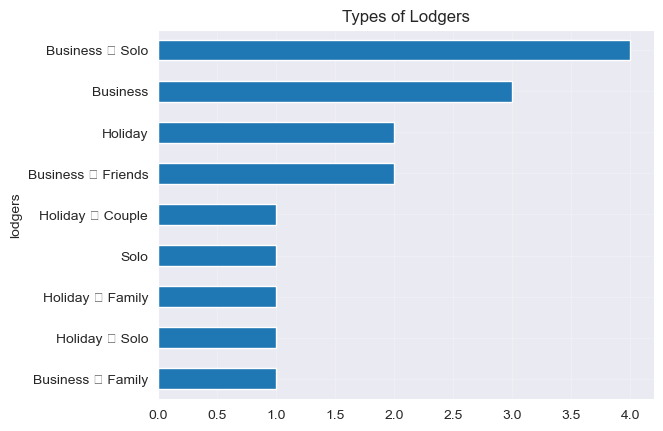

In [25]:
df.extra_info.value_counts().plot(kind='barh', title='Types of Lodgers', ylabel='lodgers')
plt.gca().invert_yaxis()
plt.grid(alpha=.2)
plt.show()

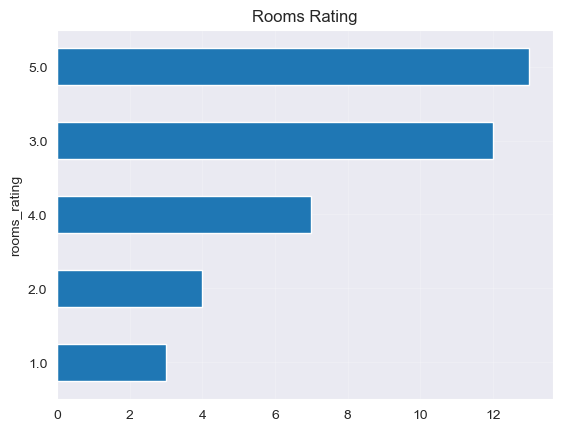

In [26]:
df.rooms_rating.value_counts().plot(kind='barh', title='Rooms Rating')
plt.gca().invert_yaxis()
plt.grid(alpha=.2)
plt.show()

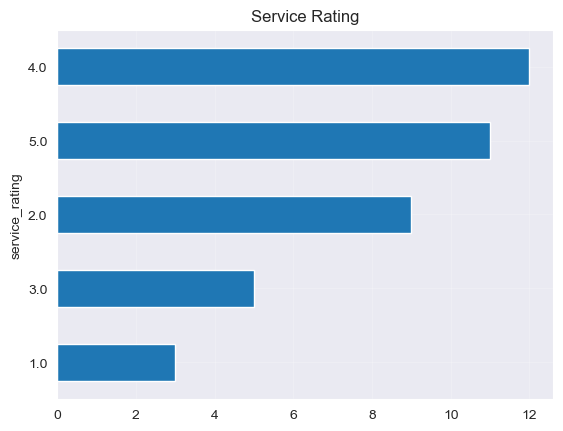

In [27]:
df.service_rating.value_counts().plot(kind='barh', title='Service Rating')
plt.gca().invert_yaxis()
plt.grid(alpha=.2)
plt.show()

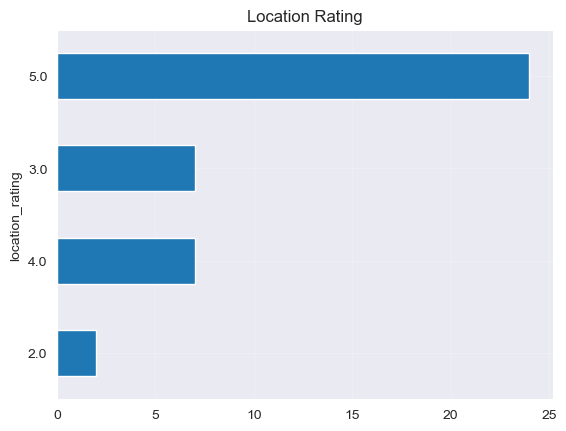

In [28]:
df.location_rating.value_counts().plot(kind='barh', title='Location Rating')
plt.gca().invert_yaxis()
plt.grid(alpha=.2)
plt.show()

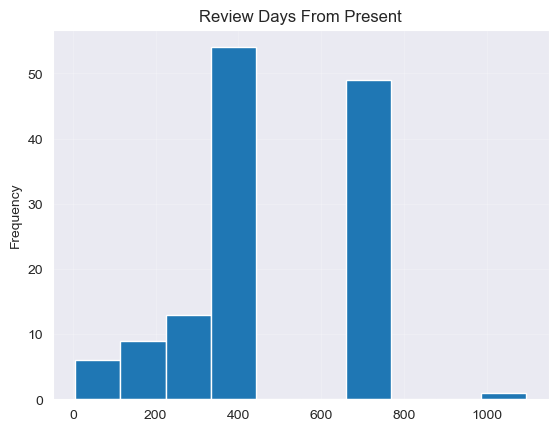

In [29]:
df.review_date_days.plot(kind='hist', title='Review Days From Present')
plt.grid(alpha=.2)
plt.show()

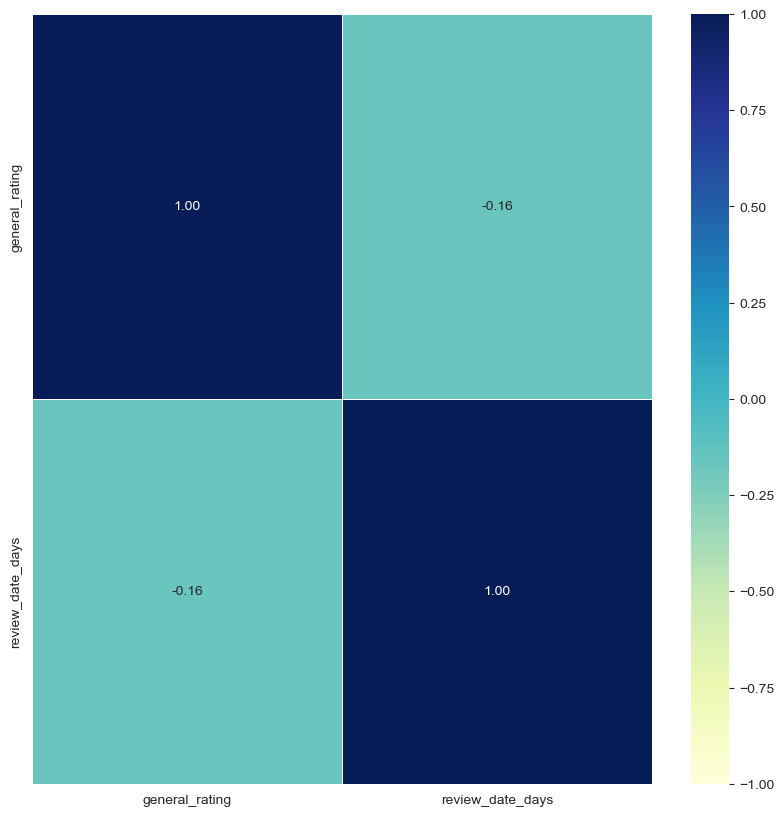

In [30]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    df[['general_rating', 'review_date_days']].corr(numeric_only=True),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu");

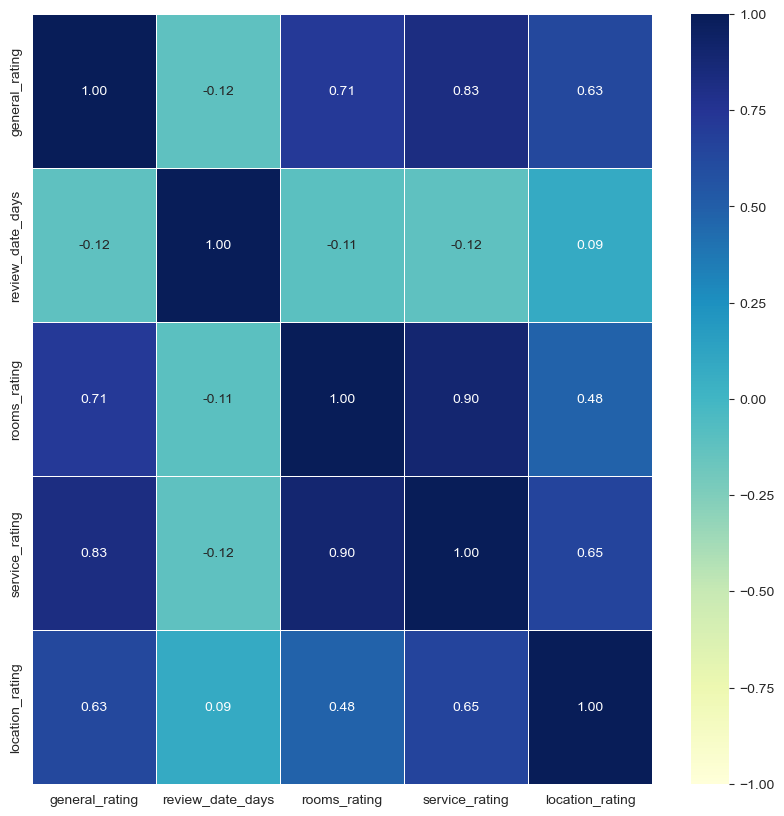

In [31]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    df[['general_rating', 'review_date_days', 'rooms_rating',
        'service_rating', 'location_rating']].dropna().corr(numeric_only=True),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu");

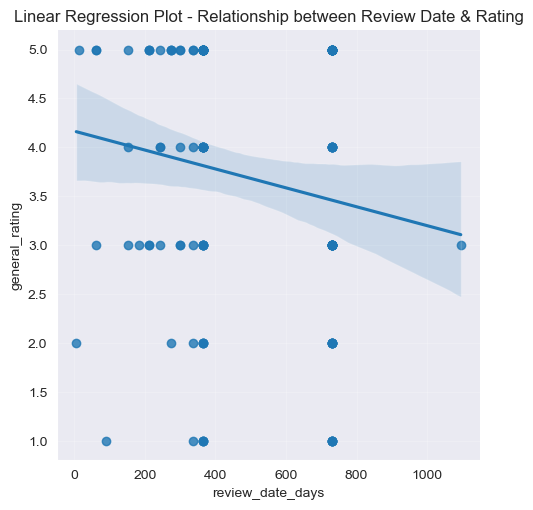

                            OLS Regression Results                            
Dep. Variable:         general_rating   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.489
Date:                Wed, 10 Jan 2024   Prob (F-statistic):             0.0640
Time:                        13:07:39   Log-Likelihood:                -224.20
No. Observations:                 132   AIC:                             452.4
Df Residuals:                     130   BIC:                             458.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.1662      0.269  

In [32]:
sns.lmplot(x='review_date_days', y='general_rating', data=df)
plt.title('Linear Regression Plot - Relationship between Review Date & Rating')
plt.grid(alpha=.2)
plt.show()

X = df['review_date_days']
y = df['general_rating']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

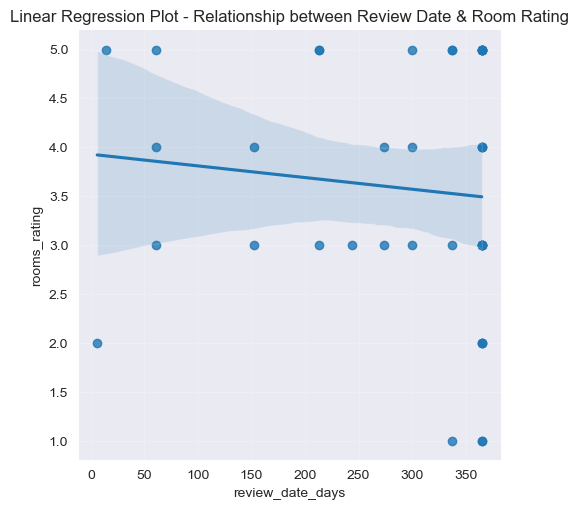

                            OLS Regression Results                            
Dep. Variable:           rooms_rating   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.4223
Date:                Wed, 10 Jan 2024   Prob (F-statistic):              0.520
Time:                        13:07:39   Log-Likelihood:                -63.979
No. Observations:                  39   AIC:                             132.0
Df Residuals:                      37   BIC:                             135.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.9297      0.562  

In [33]:
sns.lmplot(x='review_date_days', y='rooms_rating', data=df)
plt.title('Linear Regression Plot - Relationship between Review Date & Room Rating')
plt.grid(alpha=.2)
plt.show()

X = df.loc[df.rooms_rating.notnull(), 'review_date_days']
y = df.loc[df.rooms_rating.notnull(), 'rooms_rating']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

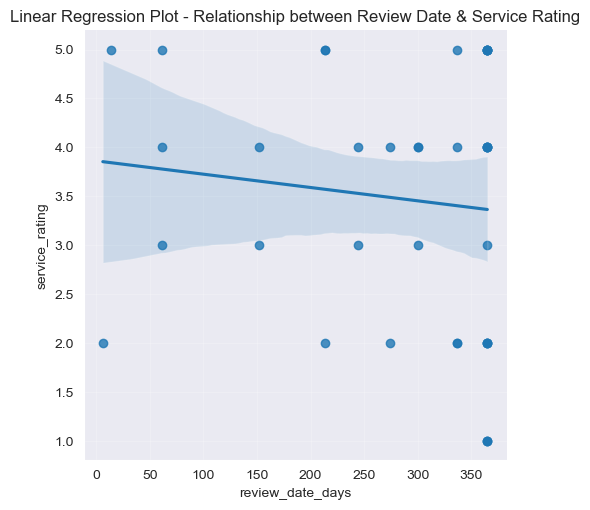

                            OLS Regression Results                            
Dep. Variable:         service_rating   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.5141
Date:                Wed, 10 Jan 2024   Prob (F-statistic):              0.478
Time:                        13:07:40   Log-Likelihood:                -67.094
No. Observations:                  40   AIC:                             138.2
Df Residuals:                      38   BIC:                             141.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.8619      0.579  

In [34]:
sns.lmplot(x='review_date_days', y='service_rating', data=df)
plt.title('Linear Regression Plot - Relationship between Review Date & Service Rating')
plt.grid(alpha=.2)
plt.show()

X = df.loc[df.service_rating.notnull(), 'review_date_days']
y = df.loc[df.service_rating.notnull(), 'service_rating']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

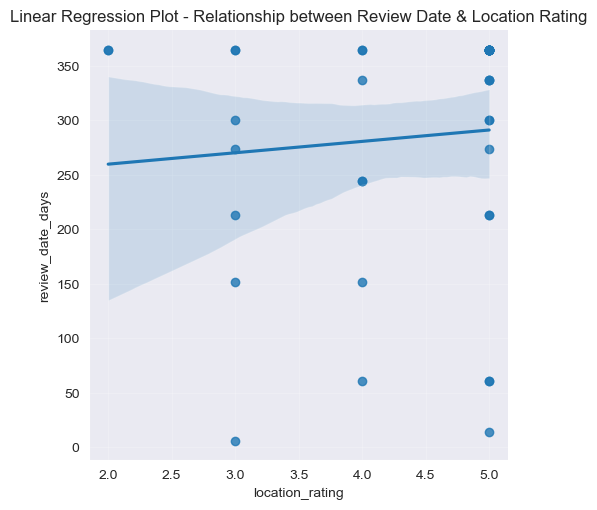

                            OLS Regression Results                            
Dep. Variable:        location_rating   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.2971
Date:                Wed, 10 Jan 2024   Prob (F-statistic):              0.589
Time:                        13:07:40   Log-Likelihood:                -53.802
No. Observations:                  40   AIC:                             111.6
Df Residuals:                      38   BIC:                             115.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.1140      0.415  

In [35]:
sns.lmplot(x='location_rating', y='review_date_days', data=df)
plt.title('Linear Regression Plot - Relationship between Review Date & Location Rating')
plt.grid(alpha=.2)
plt.show()

X = df.loc[df.location_rating.notnull(), 'review_date_days']
y = df.loc[df.location_rating.notnull(), 'location_rating']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

### Text Review Analysis

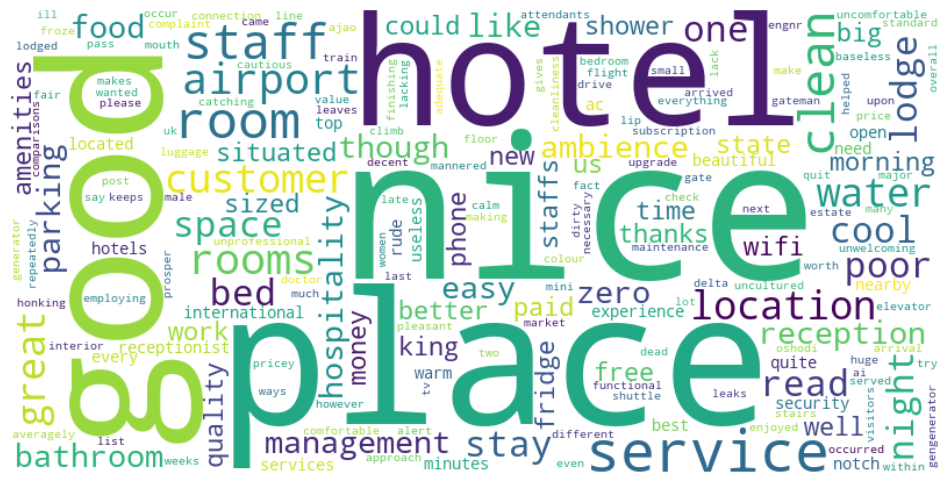

In [36]:
# Define stopwords (articles and prepositions)
stop_words = set(stopwords.words('english'))
custom_stopwords = {'a', 'an', 'the', 'in', 'on', 'at'}  
stop_words = stop_words.union(custom_stopwords)

# Function to preprocess text and remove stopwords
def preprocess_text(text):
    word_tokens = word_tokenize(text.lower())
    filtered_words = [word for word in word_tokens if word.isalpha() and word not in stop_words]
    return " ".join(filtered_words)

# Preprocess text in the DataFrame
preprocessed = df.review[df.review.notnull()].apply(preprocess_text)

all_words = [word for word in preprocessed]
text = ' '.join(all_words)

word_counts = Counter(text.split())

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_counts)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

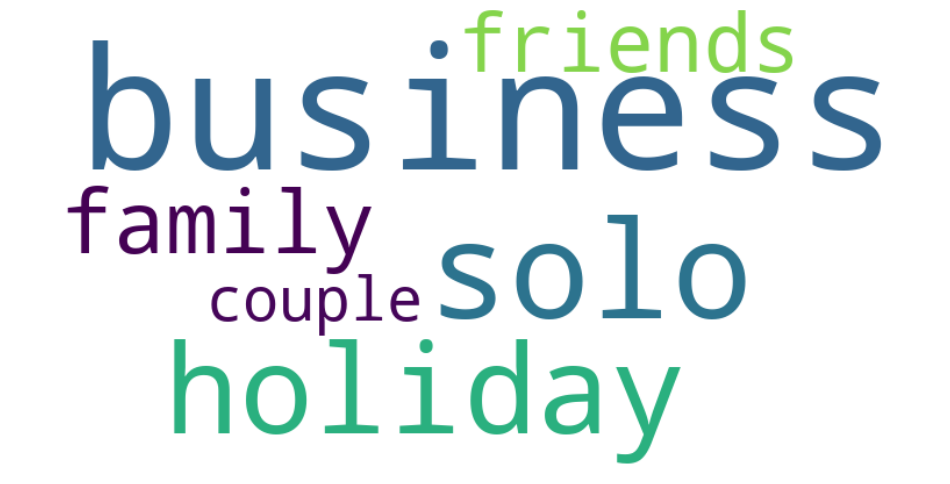

In [37]:
preprocessed = df.extra_info[df.extra_info.notnull()].apply(preprocess_text)

all_words = [word for word in preprocessed]
text = ' '.join(all_words)

word_counts = Counter(text.split())

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_counts)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

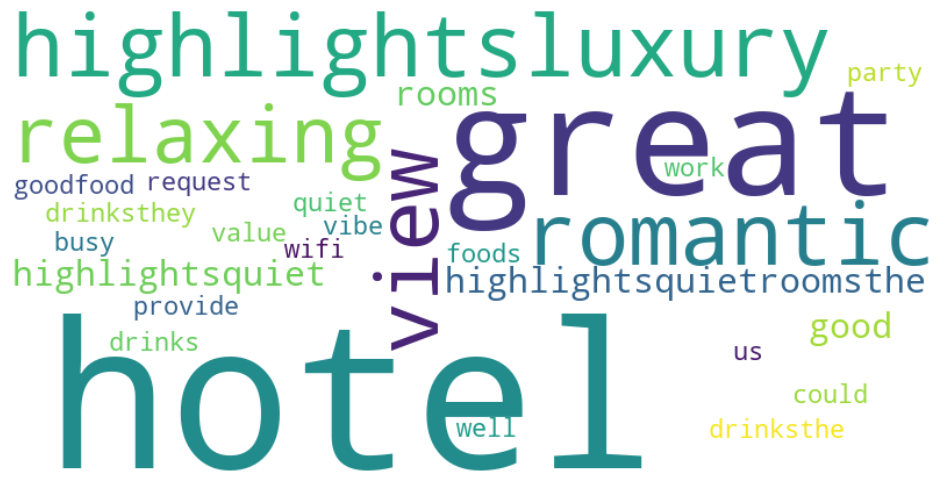

In [38]:
preprocessed = df.specific_review[df.specific_review.notnull()].apply(preprocess_text)

all_words = [word for word in preprocessed]
text = ' '.join(all_words)

word_counts = Counter(text.split())

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_counts)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [39]:
all_tokens = [token for sublist in df['clean_text'] for token in sublist]

# Calculate word frequency
word_freq = Counter(all_tokens)

# Display the most common words
print('Most Common Word in Reviews')
print(word_freq.most_common(10))

Most Common Word in Reviews
[('none', 60), ('nice', 22), ('place', 19), ('good', 16), ('hotel', 14), ('service', 11), ('room', 9), ('clean', 8), ('staff', 8), ('airport', 6)]


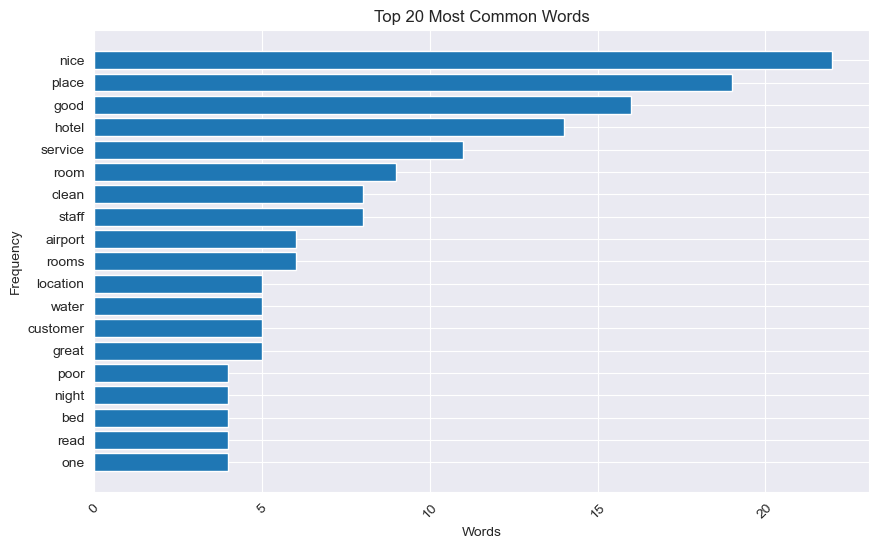

In [40]:
top_words = word_freq.most_common(20)[1:] # First value is none
plt.figure(figsize=(10, 6))
plt.barh(*zip(*top_words))
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.gca().invert_yaxis()
plt.show()

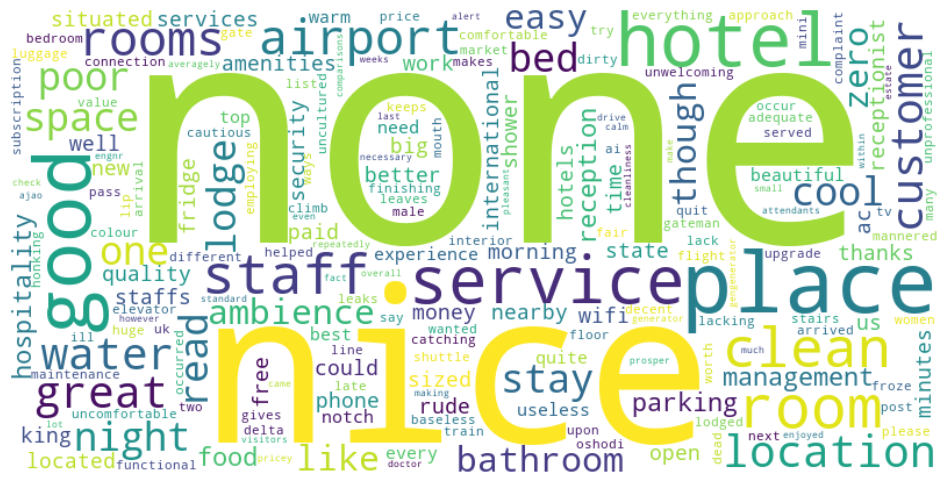

In [41]:
text = ' '.join(all_tokens)
word_counts = Counter(text.split())

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_counts)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [42]:
all_tokens = [token for sublist in df.loc[df.review_date_days <= 365, 'clean_text'] for token in sublist]

# Calculate word frequency
word_freq = Counter(all_tokens)

# Display the most common words
print('Most Common Word in Reviews Less than 1 Year Old')
print(word_freq.most_common(10))

Most Common Word in Reviews Less than 1 Year Old
[('none', 43), ('place', 12), ('nice', 11), ('good', 10), ('hotel', 6), ('service', 5), ('staff', 5), ('clean', 4), ('room', 4), ('lodge', 4)]


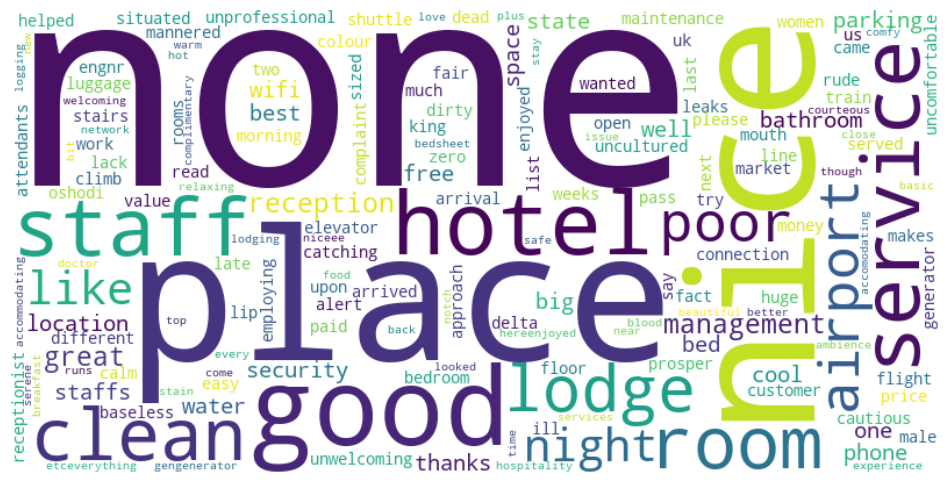

In [43]:
text = ' '.join(all_tokens)
word_counts = Counter(text.split())

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_counts)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [44]:
all_tokens = [token for sublist in df.loc[df.review_date_days <= 365/2, 'clean_text'] for token in sublist]

# Calculate word frequency
word_freq = Counter(all_tokens)

# Display the most common words
print('Most Common Word in Reviews Less than 6 Months Old')
print(word_freq.most_common(10))

Most Common Word in Reviews Less than 6 Months Old
[('none', 4), ('hotel', 2), ('well', 1), ('situated', 1), ('easy', 1), ('shuttle', 1), ('airport', 1), ('connection', 1), ('poor', 1), ('lack', 1)]


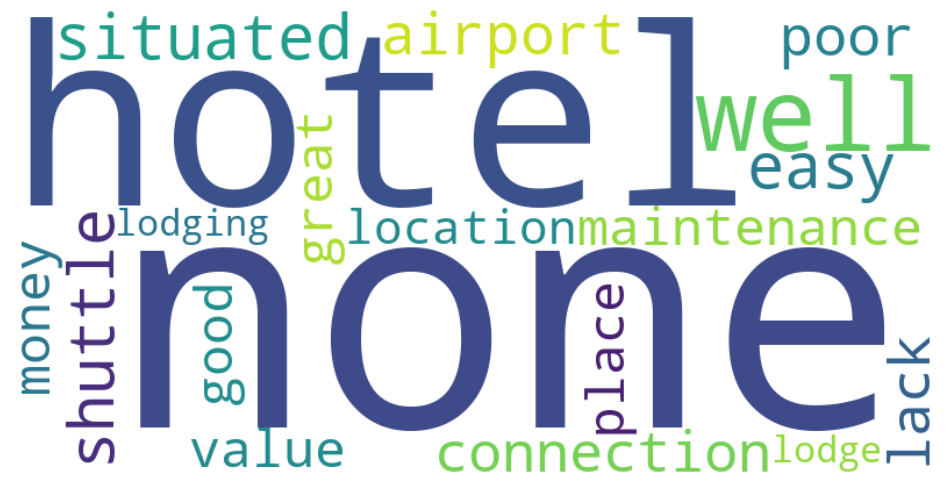

In [45]:
text = ' '.join(all_tokens)
word_counts = Counter(text.split())

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_counts)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Sentiment Analysis

In [46]:
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    return sia.polarity_scores(text)

# Apply the sentiment analyzer to the text column
df['sentiment_scores'] = df['review'].fillna('None').apply(get_sentiment_scores)

# Extract compound sentiment score and categorize it
df['compound_score'] = df['sentiment_scores'].apply(lambda score: score['compound'])

# Categorize sentiment based on the compound score
df['sentiment'] = df['compound_score'].apply(lambda score: 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral'))

# Display the DataFrame with sentiment scores and categories
df[['review', 'compound_score', 'sentiment']].head()

,review,compound_score,sentiment
0,This hotel is well situated and easy to shuttl...,0.1548,Positive
1,The hotel lack maintenance and there is no val...,-0.2732,Negative
2,Very poor service. i arrived late night from U...,-0.3167,Negative
3,How can a big hotel as this with huge price li...,-0.7244,Negative
4,"Nice place and location, king sized bed, free ...",0.6915,Positive


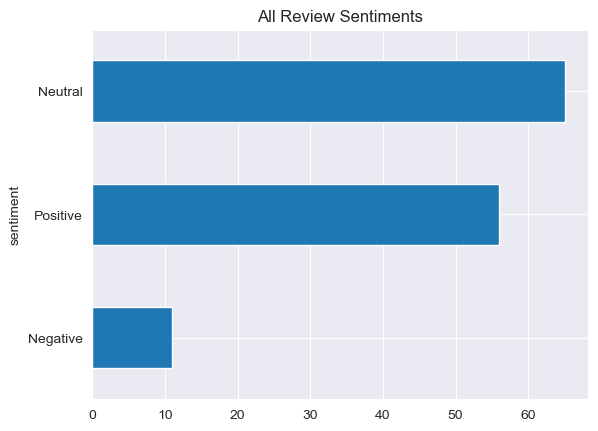

In [47]:
df['sentiment'].value_counts().plot(kind='barh', title='All Review Sentiments')
plt.gca().invert_yaxis()
plt.show()

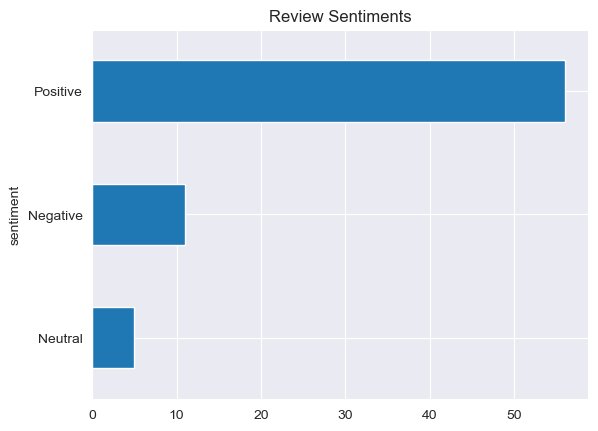

In [48]:
df.loc[df.review.notnull(), 'sentiment'].value_counts().plot(kind='barh', title='Review Sentiments')
plt.gca().invert_yaxis()
plt.show()

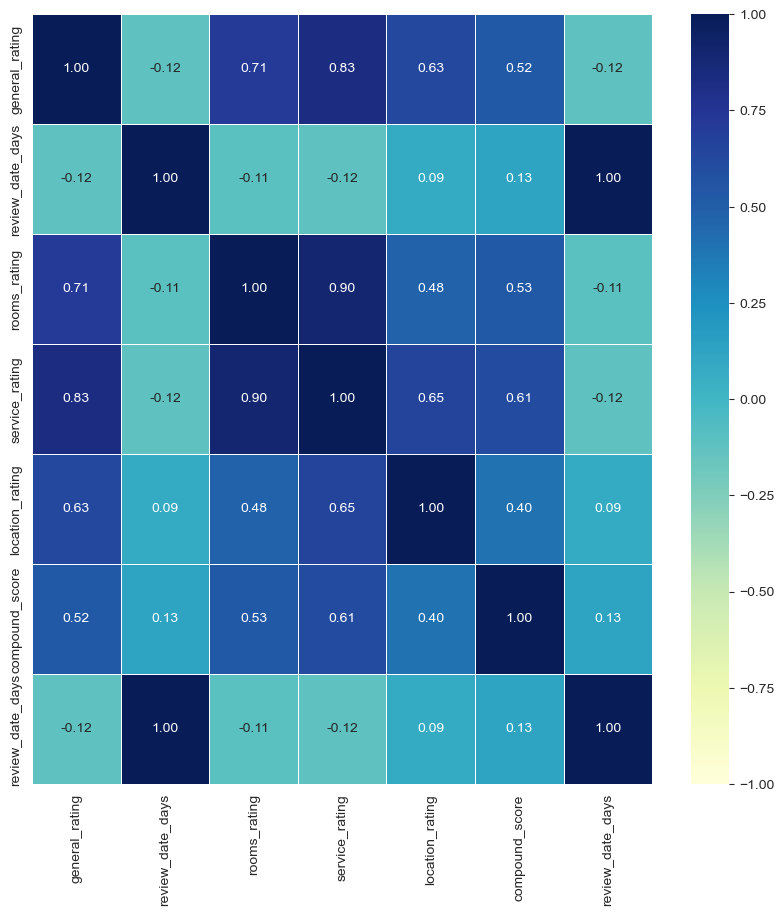

In [49]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    df[['general_rating', 'review_date_days', 'rooms_rating',
        'service_rating', 'location_rating', 'compound_score', 'review_date_days']].dropna().corr(numeric_only=True),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu");

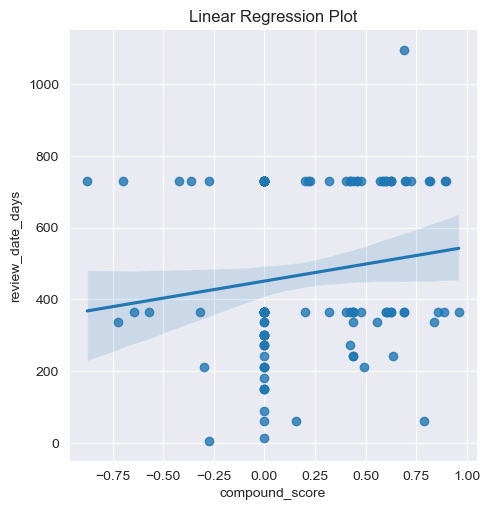

                            OLS Regression Results                            
Dep. Variable:         compound_score   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.153
Date:                Wed, 10 Jan 2024   Prob (F-statistic):             0.0781
Time:                        13:07:44   Log-Likelihood:                -52.171
No. Observations:                 132   AIC:                             108.3
Df Residuals:                     130   BIC:                             114.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0765      0.073  

In [50]:
sns.lmplot(x='compound_score', y='review_date_days', data=df)
plt.title('Linear Regression Plot')
plt.show()

X = df['review_date_days']
y = df['compound_score']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())